#### GP regression is a non-parametric approach to reconstructing observational data which are incorporated as a finite collection of normally distributed points. This type of supervised learning is implemented for stochastic data whose data points are related together enough such that a covariance function can be fit in such a way as to prescribe these relations in a specific way. In practice a GP is defined in terms of the mean function $\mu(z)$ together with its associated two-point covariant function $\mathcal{C}(z,\tilde{z})$ which produces the continuous realization
\begin{equation}
	\xi(z)\sim\mathcal{GP}\left(\mu(z),\mathcal{C}(z,\tilde{z})\right)\,,
\end{equation}
where the uncertainty $\Delta\xi(z)$ is also part of the reconstruction which produces a realization region $\xi(z) \pm \Delta \xi(z)$. By and large the mean is set to zero without loss of generality so that the covariance function becomes the defining feature for each reconstructed data set. For redshift points $z^*$ which represent points where observations do not occur, we can define a kernel function for the covariance function such that $\mathcal{K}\left(z^*,z^{*'}\right) = \mathcal{C}\left(z^*,z^{*'}\right)$ where the trained covariance function is utilised. Thus, the kernel will embody all the information about the strength and amplitude of the correlations between the redshift data points. The only strong requirement on the kernel is that it is a symmetric function.

For observational point $\tilde{z}$, we also have available to us information on the associated uncertainty region covariance matrix $\mathcal{D}\left(\tilde{z},\tilde{z}'\right)$ between data points. Thus, the covariance function for these points can be written as $\mathcal{C}\left(\tilde{z},\tilde{z}'\right) = \mathcal{K}\left(\tilde{z},\tilde{z}'\right) + \mathcal{D}\left(\tilde{z},\tilde{z}'\right)$ which will provide information to fit the kernel. Naturally, observational and reconstructed points can be interrelated by the kernel alone through $\mathcal{C}\left(z^*,\tilde{z}'\right) = \mathcal{K}\left(z^*,\tilde{z}'\right)$.

Therefore, for a Gaussian distribution, the posterior distribution of a reconstructed function can be expressed via the joint Gaussian distribution of different data points in which the kernel expresses the interrelated mean value and uncertainties of each point in the resulting distribution.

We use the squared-exponential kernel but there exist a plethora of such kernel options. Despite each producing a slightly different non-parametric reconstruction of a distribution, they largely agree to well within $1\sigma$ confidence regions. The general purpose squared-exponential kernel is explicitly defined as
\begin{equation}
	\mathcal{K}\left(z,\tilde{z}\right) = \sigma_f^2 \exp\left[-\frac{\left(z-\tilde{z}\right)^2}{2l_f^2}\right]\,,
\end{equation}
where $\sigma_f$ and $l_f$ are the kernel hyperparameters, which are parameters of the kernel but do not parameterise the function being reconstructed, as a model would. The hyperparameters characterise the variance in the data through $\sigma_f$ and the length-scale through $l_f$. Thus, the hyperparameters define the smoothness and reach for fluctuations in a signal. As a result, larger values of $l_f$ lead to smoother GP functions while higher values of $\sigma_f$ express a lower signal-to-noise ratio.

To determine the best suited hyperparameters, their values are derived from the maximisation of the probability of the GP to generate the data set under consideration which is implemented via the minimisation of the GP marginal likelihood similar to a Bayesian approach.

GP regression has now been extensively studied as a tool for reconstructions in the cosmological context which have largely focused on the late-time behaviour of the expansion rate.

#### We will be applying GPyTorch which is a Gaussian process library implemented using PyTorch. GPyTorch is designed for creating scalable, flexible, and modular Gaussian process models with ease.

#### Internally, GPyTorch differs from many existing approaches to GP inference by performing most inference operations using numerical linear algebra techniques like preconditioned conjugate gradients. Implementing a scalable GP method is as simple as providing a matrix multiplication routine with the kernel matrix and its derivative via our LinearOperator interface, or by composing many of our already existing LinearOperators. This allows not only for easy implementation of popular scalable GP techniques, but often also for significantly improved utilization of GPU computing compared to solvers based on the Cholesky decomposition.


https://pypi.org/project/gpytorch/

Gardner, Jacob R., Geoff Pleiss, David Bindel, Kilian Q. Weinberger, and Andrew Gordon Wilson. "GPyTorch: Blackbox Matrix-Matrix Gaussian Process Inference with GPU Acceleration." In Advances in Neural Information Processing Systems (2018). https://arxiv.org/abs/1809.11165

https://gpytorch.ai/

In [1]:
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Corfu_Lectures/

/content/drive/MyDrive/Corfu_Lectures


In [4]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy
import pandas as pd

In [5]:
# Load JLA data set
jla_data = pd.read_csv('data/JLA.csv')

# Load mb and corresponding errors
train_y = torch.tensor(jla_data['mb'].values)
y_err = torch.tensor(jla_data['errors'].values)

# Load redshifts
train_x = torch.tensor(jla_data['zcmb'].values)

## Setting up the model

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.

2. A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.

3. A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)

4. A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).

5. A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.

## Training the model

In GPyTorch, we make use of the standard PyTorch optimizers as from torch.optim, and all trainable parameters of the model should be of type torch.nn.Parameter. Because GP models directly extend torch.nn.Module, calls to methods like model.parameters() or model.named_parameters() function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients

2. Call the model and compute the loss

3. Call backward on the loss to fill in gradients

4. Take a step on the optimizer

## **Matern kernel**

In [6]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=1))

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 1.3, 200)
    observed_pred = likelihood(model(test_x))

Iter 1/200 - Loss: 1.705
Iter 2/200 - Loss: 1.613
Iter 3/200 - Loss: 1.532
Iter 4/200 - Loss: 1.461
Iter 5/200 - Loss: 1.397
Iter 6/200 - Loss: 1.337
Iter 7/200 - Loss: 1.279
Iter 8/200 - Loss: 1.221
Iter 9/200 - Loss: 1.165
Iter 10/200 - Loss: 1.110
Iter 11/200 - Loss: 1.056
Iter 12/200 - Loss: 1.004
Iter 13/200 - Loss: 0.954
Iter 14/200 - Loss: 0.906
Iter 15/200 - Loss: 0.861
Iter 16/200 - Loss: 0.819
Iter 17/200 - Loss: 0.780
Iter 18/200 - Loss: 0.743
Iter 19/200 - Loss: 0.710
Iter 20/200 - Loss: 0.679
Iter 21/200 - Loss: 0.652
Iter 22/200 - Loss: 0.628
Iter 23/200 - Loss: 0.607
Iter 24/200 - Loss: 0.588
Iter 25/200 - Loss: 0.573
Iter 26/200 - Loss: 0.560
Iter 27/200 - Loss: 0.550
Iter 28/200 - Loss: 0.542
Iter 29/200 - Loss: 0.536
Iter 30/200 - Loss: 0.530
Iter 31/200 - Loss: 0.525
Iter 32/200 - Loss: 0.520
Iter 33/200 - Loss: 0.515
Iter 34/200 - Loss: 0.509
Iter 35/200 - Loss: 0.502
Iter 36/200 - Loss: 0.495
Iter 37/200 - Loss: 0.487
Iter 38/200 - Loss: 0.479
Iter 39/200 - Loss: 0

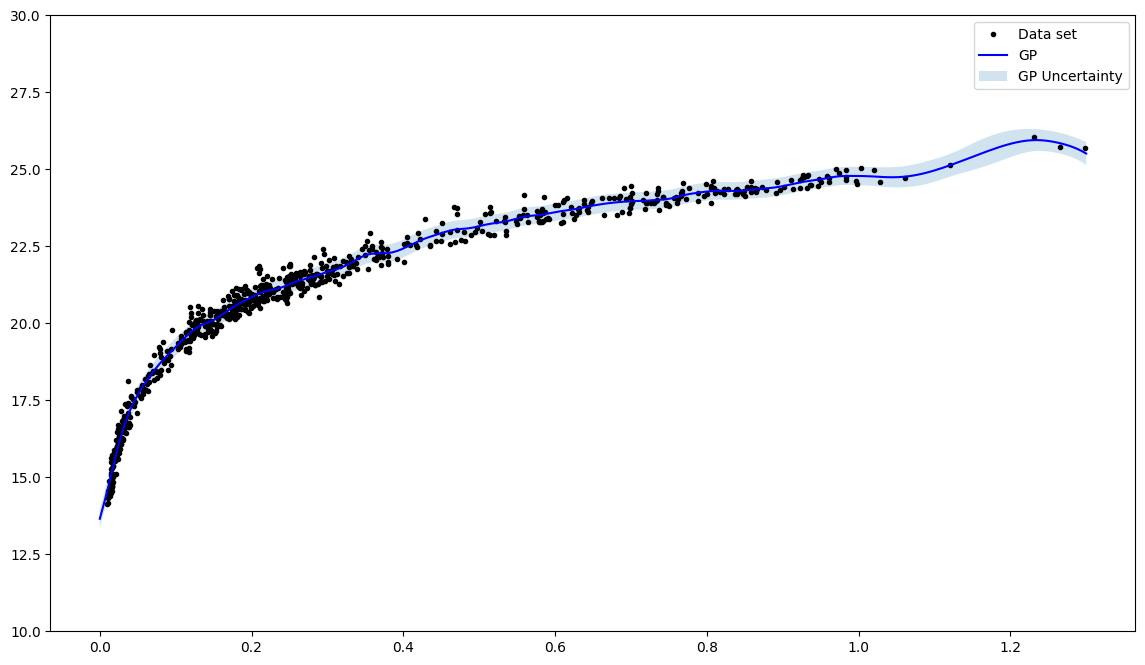

In [7]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k.',label='Data set')
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(test_x.numpy(), observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()), observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()), alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## RBF Kernel

In [8]:
# Gaussian process class
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        ''' An __init__ method that takes the training data and a likelihood,
        and constructs whatever objects are necessary for the model’s forward method.
        This will most commonly include things like a mean module and a kernel module.'''
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        ''' A forward method that takes in some data x and returns a
        MultivariateNormal with the prior mean and covariance evaluated at x.
        In other words, we return the vector mu(x) and the matrix representing the
        prior mean and covariance matrix of the GP. '''
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialisation of the GP likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GaussianProcess(train_x, train_y, likelihood)

# GP training - Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# refer to https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# refer to https://docs.gpytorch.ai/en/latest/marginal_log_likelihoods.html
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

# Generate GP inferred predictions
model.eval()
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 1.3, 200)
    observed_pred = likelihood(model(test_x))

Iter 1/200 - Loss: 1.857
Iter 2/200 - Loss: 1.788
Iter 3/200 - Loss: 1.715
Iter 4/200 - Loss: 1.638
Iter 5/200 - Loss: 1.562
Iter 6/200 - Loss: 1.493
Iter 7/200 - Loss: 1.435
Iter 8/200 - Loss: 1.384
Iter 9/200 - Loss: 1.334
Iter 10/200 - Loss: 1.286
Iter 11/200 - Loss: 1.239
Iter 12/200 - Loss: 1.192
Iter 13/200 - Loss: 1.143
Iter 14/200 - Loss: 1.091
Iter 15/200 - Loss: 1.039
Iter 16/200 - Loss: 0.992
Iter 17/200 - Loss: 0.951
Iter 18/200 - Loss: 0.914
Iter 19/200 - Loss: 0.878
Iter 20/200 - Loss: 0.845
Iter 21/200 - Loss: 0.818
Iter 22/200 - Loss: 0.795
Iter 23/200 - Loss: 0.775
Iter 24/200 - Loss: 0.758
Iter 25/200 - Loss: 0.743
Iter 26/200 - Loss: 0.730
Iter 27/200 - Loss: 0.719
Iter 28/200 - Loss: 0.709
Iter 29/200 - Loss: 0.698
Iter 30/200 - Loss: 0.687
Iter 31/200 - Loss: 0.675
Iter 32/200 - Loss: 0.662
Iter 33/200 - Loss: 0.649
Iter 34/200 - Loss: 0.636
Iter 35/200 - Loss: 0.624
Iter 36/200 - Loss: 0.614
Iter 37/200 - Loss: 0.604
Iter 38/200 - Loss: 0.596
Iter 39/200 - Loss: 0

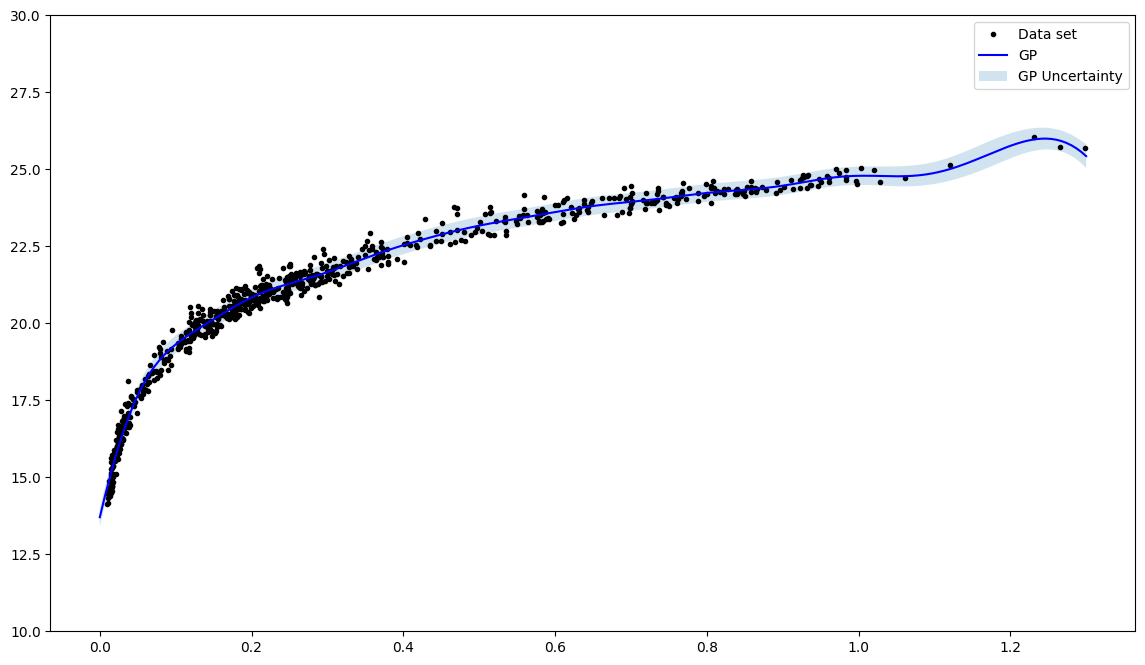

In [9]:
# Illustrate data set along with the GP prediction
with torch.no_grad():
    plt.figure(figsize=(14, 8))
    plt.plot(train_x.numpy(), train_y.numpy(), 'k.',label='Data set')
    plt.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='GP')
    plt.fill_between(test_x.numpy(), observed_pred.mean.numpy() - numpy.sqrt(observed_pred.variance.numpy()), observed_pred.mean.numpy() + numpy.sqrt(observed_pred.variance.numpy()), alpha=0.2, label='GP Uncertainty')
    plt.ylim((10, 30))
    plt.legend()
    plt.show()

## Pantheon+

## Implement the same GP algorithms to the Pantheon+ data sets which should be downloaded from https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR

## -> Pantheon+SH0ES.dat
## -> Pantheon+SH0ES_STAT+SYS.cov

## Matern kernel

## RBF kernel

## Do you think that the inferred GP reconstructions can be improved? How?

## Decision Trees

#### Hold out validation splits the data in two, one set to test with and the other to train with. Hold out validation is the most basic form of validation.

#### While hold-out validation is better than no validation, the measured accuracy will vary depending on how we split the data into testing and training subsets.

#### In order to be more certain of our models accuracy we should use $k$-fold cross validation. $k$-fold validation works in a similar way to hold-out except that we split the data into $k$ subsets. We train and test the model $k$ times, recording the accuracy each time. Each time we use a different combination of $k$ subsets to train the model and the final $k^{th}$ subset to test. We take the average of the $k$ accuracy measurements to be the overall accuracy of the the model.

#### The KFold library is designed to split the data into training and testing subsets. It does this by offering an iterable object that can be initialised with

#### kf = KFold(n_splits=k, shuffle=True)

#### The n_splits=k specifies the number of subsets to use.

#### By default shuffle is set to false. It is generally good practice to shuffle the data for cross validation as sometimes during collection and storage, data of a similar type can be stored adjacently which would lead to some learning bias when training the tree. For example, if the data was sorted by redshift, on the first iteration the model might be trained with redshifts 0 to 3 and tested on galaxies with redshifts ~4.

Median difference: 0.017


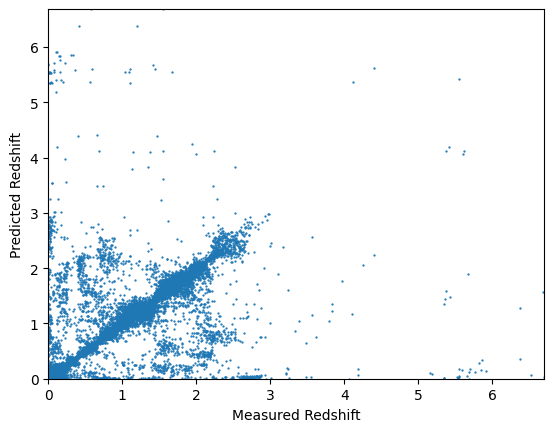

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

# your get_features_targets function here
def get_features_targets(data):
  features = np.zeros((data.shape[0], 4))
  features[:, 0] = data['u'] - data['g']
  features[:, 1] = data['g'] - data['r']
  features[:, 2] = data['r'] - data['i']
  features[:, 3] = data['i'] - data['z']
  targets = data['redshift']
  return features, targets

# your median_diff function here
def median_diff(predicted, actual):
  return np.median(np.abs(predicted - actual))

# cross_validate_predictions
def cross_validate_predictions(model, features, targets, k):
  kf = KFold(n_splits=k, shuffle=True)

  # declare an array for predicted redshifts from each iteration
  all_predictions = np.zeros_like(targets)

  for train_indices, test_indices in kf.split(features):
    # split the data into training and testing
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]

    # fit the model for the current set
    model.fit(train_features, train_targets)

    # predict using the model
    predictions = model.predict(test_features)

    # put the predicted values in the all_predictions array defined above
    all_predictions[test_indices] = predictions

  # return the predictions
  return all_predictions


if __name__ == "__main__":
  data = np.load('sdss_galaxy_colors.npy')
  features, targets = get_features_targets(data)

  # initialize model
  dtr = DecisionTreeRegressor(max_depth=19)

  # call your cross validation function
  predictions = cross_validate_predictions(dtr, features, targets, 10)

  # calculate and print the rmsd as a sanity check
  diffs = median_diff(predictions, targets)
  print('Median difference: {:.3f}'.format(diffs))

  # plot the results to see how well our model looks
  plt.scatter(targets, predictions, s=0.4)
  plt.xlim((0, targets.max()))
  plt.ylim((0, predictions.max()))
  plt.xlabel('Measured Redshift')
  plt.ylabel('Predicted Redshift')
  plt.show()

#### K-Fold cross validation is an important part of assessing the accuracy of any machine learning model. When we plotted our predicted vs measured redshifts we are able to see that for many our galaxies we were able to get a reasonably accurate prediction of redshift. However, there are also several outliers where our model does not give a good prediction.